## Import Libraries and load cifar10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Subset
#import additional libraries if needed
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [16]:
def load_cifar10_data(batch_size):
# load both training and test datasets, and transform them to tensors.
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainset.data = trainset.data[:30000]
  trainset.targets = trainset.targets[:30000]
  print("train",len(trainset))
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  #testset.data = testset.data[:2000]
  #testset.targets = testset.targets[:2000]
  print("test",len(testset))
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  
  return trainset, testset, trainloader, testloader

In [17]:
batch_size = 4
trainset, testset, trainloader, testloader = load_cifar10_data(batch_size)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
train 30000
Files already downloaded and verified
test 10000


In [4]:
# Check the dimensions of a batch:
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([4, 3, 32, 32])
Image label dimensions: torch.Size([4])


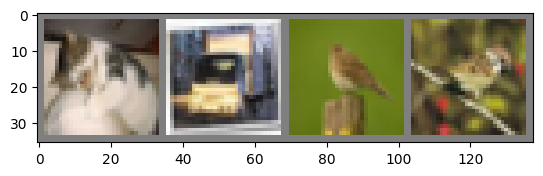

cat   truck bird  bird 


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Section 1: Define your CNN model
Define your output layer, optimizer and loss criterion

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #TODO: Define your CNN here
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # ...
        # input shape: 3x32x32

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        # Max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully-connected layers
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        #TODO: Compute the forward pass here
        # x = self.pool(F.relu(self.conv1(x)))
         # Convolutional layers
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully-connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
#create model
model = CustomCNN()

## Section 2: Define optimizer and loss criterion

In [8]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 10

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# loss
loss = nn.CrossEntropyLoss()

In [9]:
"""DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)"""

'DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nprint(\'Device:\', DEVICE)\n# Set my pretrained model to be run on GPU\nmodel = model.to(DEVICE)'

In [10]:
"""# Helper function to compute the accuracy
def compute_accuracy(model, dataloader):
    num_correct = 0
    num_samples = 0
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    model.train() # set the model back to training mode
    accuracy = float(num_correct) / num_samples
    return accuracy"""

'# Helper function to compute the accuracy\ndef compute_accuracy(model, dataloader):\n    num_correct = 0\n    num_samples = 0\n    model.eval() # set the model to evaluation mode\n    with torch.no_grad():\n        for x, y in dataloader:\n            x = x.to(DEVICE)\n            y = y.to(DEVICE)\n            scores = model(x)\n            _, preds = scores.max(1)\n            num_correct += (preds == y).sum()\n            num_samples += preds.size(0)\n    model.train() # set the model back to training mode\n    accuracy = float(num_correct) / num_samples\n    return accuracy'

In [11]:
"""def compute_epoch_loss(model, dataloader):
    loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            scores = model(x)
            loss += F.cross_entropy(scores, y, reduction='sum').item()
    model.train()
    num_samples = len(dataloader.dataset)
    epoch_loss = loss / num_samples
    return epoch_loss"""

    

"def compute_epoch_loss(model, dataloader):\n    loss = 0\n    model.eval()\n    with torch.no_grad():\n        for x, y in dataloader:\n            x = x.to(DEVICE)\n            y = y.to(DEVICE)\n            scores = model(x)\n            loss += F.cross_entropy(scores, y, reduction='sum').item()\n    model.train()\n    num_samples = len(dataloader.dataset)\n    epoch_loss = loss / num_samples\n    return epoch_loss"

In [12]:
"""def train_model(trainloader, num_epochs, model, optimizer, loss):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss_value = loss(outputs, labels)
            loss_value.backward()
            optimizer.step()

            
            # print statistics
            running_loss += loss_value.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
                print('[Epoch %d, Batch %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
                
                # calculate accuracy
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %d %%' % (
                    100 * correct / total))
            
            #TODO: Write your training pipeline here: call forward() and backward()
            #TODO: Print the accuracy and loss as well."""


def train_model(trainset, num_epochs, model, optimizer, loss):
    # split data into 10 folds
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_losses = []
    fold_val_accs = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
        print(f"Fold {fold + 1}")

        # get fold data
        train_fold = torch.utils.data.Subset(trainset, train_idx)
        val_fold = torch.utils.data.Subset(trainset, val_idx)

        # create data loaders
        batch_size = 32
        trainloader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size,
                                                  shuffle=True, num_workers=2)
        valloader = torch.utils.data.DataLoader(val_fold, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

        # train for num_epochs epochs
        for epoch in range(num_epochs):
            running_loss = 0.0

            for i, (inputs, labels) in enumerate(trainloader):
                optimizer.zero_grad()

                outputs = model(inputs)
                loss_value = loss(outputs, labels)
                loss_value.backward()
                optimizer.step()

                running_loss += loss_value.item()

            # calculate validation accuracy
            correct = 0
            total = 0
            with torch.no_grad():
                for val_inputs, val_labels in valloader:
                    val_outputs = model(val_inputs)
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()

            val_acc = correct / total
            fold_val_accs.append(val_acc)

            print(f"Epoch {epoch + 1}: Loss={running_loss:.4f}, Validation Accuracy={val_acc:.4f}")

        fold_losses.append(running_loss)

    # calculate final validation accuracy
    mean_val_acc = sum(fold_val_accs) / len(fold_val_accs)
    print(f"Final Validation Accuracy: {mean_val_acc:.4f}")



In [13]:
train_model(trainset, num_epochs, model, optimizer, loss)

Fold 1
Epoch 1: Loss=1241.4391, Validation Accuracy=0.5827
Epoch 2: Loss=911.8649, Validation Accuracy=0.6213
Epoch 3: Loss=772.1971, Validation Accuracy=0.6600
Epoch 4: Loss=669.3098, Validation Accuracy=0.6787
Epoch 5: Loss=589.5081, Validation Accuracy=0.7070
Epoch 6: Loss=505.9268, Validation Accuracy=0.7050
Epoch 7: Loss=440.5394, Validation Accuracy=0.6880
Epoch 8: Loss=368.4166, Validation Accuracy=0.7073
Epoch 9: Loss=305.7380, Validation Accuracy=0.7113
Epoch 10: Loss=246.9323, Validation Accuracy=0.7177
Fold 2
Epoch 1: Loss=280.2704, Validation Accuracy=0.9003
Epoch 2: Loss=212.3392, Validation Accuracy=0.8797
Epoch 3: Loss=160.1893, Validation Accuracy=0.9027
Epoch 4: Loss=112.6325, Validation Accuracy=0.9060
Epoch 5: Loss=71.5195, Validation Accuracy=0.8837
Epoch 6: Loss=55.6385, Validation Accuracy=0.8997
Epoch 7: Loss=30.5695, Validation Accuracy=0.9120
Epoch 8: Loss=16.2027, Validation Accuracy=0.9103
Epoch 9: Loss=9.1668, Validation Accuracy=0.9133
Epoch 10: Loss=6.2515

## Section 3: Test your model

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [20]:
#Test for the entire dataset

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %
